In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#plt.rc('font', size=15)
from jax import config
from jax import random
import jax.numpy as jnp
from jax.lax import fori_loop, cond
from jax import jit
from jax import vmap
from jax import debug
#from innov.simple_model import*
config.update('jax_enable_x64', True)
import pickle as pkl
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from innov.network_model_1 import *
import matplotlib.animation as animation
from itertools import chain
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from jax import debug

In [3]:
# helper functions
def body_fun(xi, mi):
    # Use lax.cond to perform the conditional logic
    return cond(mi,
                lambda _: False,  # If mi is True, return value
                lambda _: xi,     # If mi is False, return xi
                operand=None)
set_false = vmap(body_fun)

def body_fun(xi, mi):
    # Use lax.cond to perform the conditional logic
    return cond(mi,
                lambda _: True,  # If mi is True, return value
                lambda _: xi,     # If mi is False, return xi
                operand=None)
set_true = vmap(body_fun)

def body_fun(xi, mi):
    # Use lax.cond to perform the conditional logic
    return cond(mi,
                lambda _: 0,  # If mi is True, return value
                lambda _: xi,     # If mi is False, return xi
                operand=None)
set_zero = vmap(body_fun)

In [4]:

@jit
def move_innov_front_explorer(key, inn_front, in_sub_pop, obs_sub, n):
    """Move all innovation fronts stochastically.
    
    Parameters
    ----------
    key
    inn_front : boolean array
        Indicates sites that are innovation fronts using True.
    in_sub_pop : boolean array
        Indicates which sites are in the populated subgraph.
    
    Returns
    -------
    key
    inn_front
    """
    # randomly choose innovation fronts to move
    key, subkey = random.split(key)
    front_moved = inn_front * (random.uniform(subkey, (N,)) > (1 - r*I*dt*n))
    
    # randomly choose amongst children to move innovation to
    key, subkey = random.split(key)
    #new_front_ix = jnp.argmax(Ady * random.uniform(subkey, (N,N)), axis=1) * front_moved
    new_front_ix = front_moved  @ Ady * sites
    # remove parent innovation fronts
    inn_front = inn_front.at[new_front_ix].set(True)
    #inn_front = jnp.logical_xor(inn_front, obs_sub)
    # set children innovation fronts
    inn_front = inn_front.at[0].set(False)  # bookkeeping
    in_sub_pop = in_sub_pop.at[new_front_ix].set(True)
    in_sub_pop = in_sub_pop.at[0].set(False)
    return key, inn_front, in_sub_pop

@jit
def move_innov_front(key, inn_front, in_sub_pop, n):
    """Move all innovation fronts stochastically.
    
    Parameters
    ----------
    key
    inn_front : boolean array
        Indicates sites that are innovation fronts using True.
    in_sub_pop : boolean array
        Indicates which sites are in the populated subgraph.
    
    Returns
    -------
    key
    inn_front
    """
    # randomly choose innovation fronts to move
    key, subkey = random.split(key)
    front_moved = inn_front * (random.uniform(subkey, (N,)) > (1 - r*I*dt*n))
    
    # randomly choose amongst children to move innovation to
    key, subkey = random.split(key)
    new_front_ix = jnp.argmax(Ady * random.uniform(subkey, (N,N)), axis=1) * front_moved
    
    # remove parent innovation fronts
    inn_front = jnp.logical_xor(inn_front, front_moved)
    # set children innovation fronts
    inn_front = inn_front.at[new_front_ix].set(True)
    inn_front = inn_front.at[0].set(False)  # bookkeeping
    in_sub_pop = in_sub_pop.at[new_front_ix].set(True)
    
    return key, inn_front, in_sub_pop

@jit
def move_obs_front(key, obs_sub, in_sub_pop, inn_front):
    """Grow obsolescence subgraph stochastically.
    
    TODO: allow obs subgraph to expand to all children instead of choosing one
          at a time
    
    Parameters
    ----------
    key
    obs_sub : boolean array
        Indicates sites that are obsolescence graph using True.
    
    Returns
    -------
    key
    obs_sub
    """
    # randomly choose obsolesence sites to move
    key, subkey = random.split(key)
    front_moved = obs_sub * (random.uniform(subkey, (N,)) < τo*dt)
    
    # move into all children vertices
    key, subkey = random.split(key)
    #new_front_ix = jnp.argmax(Ady * random.uniform(subkey, (N,N)), axis=1) * front_moved
    new_front_ix = front_moved @ Ady * sites
    
    # set children obsolescence sites
    obs_sub = obs_sub.at[new_front_ix].set(True)
    inn_front = inn_front.at[new_front_ix].set(False)
    in_sub_pop = in_sub_pop.at[new_front_ix].set(False)
    
    return key, obs_sub, in_sub_pop, inn_front


@jit
def one_loop(i, val):
    key = val[0]
    inn_front = val[1]
    obs_sub = val[2]
    in_sub_pop = val[3]
    n = val[4]

    # move innovation front
    #key, inn_front, in_sub_pop = move_innov_front(key, inn_front, in_sub_pop, n)
    key, inn_front, in_sub_pop = move_innov_front_explorer(key, inn_front, in_sub_pop, obs_sub, n)
#     debug.print("{x}", x=inn_front)
    
    # replicate
    key, subkey = random.split(key)
    to_replicate = random.poisson(subkey, Ady.T @ (r * inverse_sons * n * dt))
    n = n + to_replicate
#     debug.print("DREP {x}", x=(Ady.T @ (r * inverse_sons * n * dt))[:10])
#     debug.print("REP {x}", x=n[:10])
    
    # death
    key, subkey = random.split(key)
    to_died = random.poisson(subkey, rd * n * dt)
    n = jnp.maximum(n - to_died, 0)

    # growth
    key, subkey = random.split(subkey)
    G_dt = random.poisson(subkey, G_in*dt/in_sub_pop.sum(), (N,))
    n = (n + G_dt) * in_sub_pop

    # obsolescence front 
    key, obs_sub, in_sub_pop, inn_front = move_obs_front(key, obs_sub, in_sub_pop, inn_front)
    n = set_zero(n, obs_sub)
#     debug.print("OBS {x}", x=n[:10])
    
    return [key, inn_front, obs_sub, in_sub_pop, n]

@jit
def run_multiple_sims(i, val):
    key = val[0]
    inn_front_1 = val[1]
    obs_sub_1 = val[2]
    in_sub_pop_1 = val[3]
    n_1 = val[4]
    inn_front = val[5]
    obs_sub = val[6]
    in_sub_pop = val[7]
    n = val[8]
    
    key, inn_front_2, obs_sub_2, in_sub_pop_2, n_2 = fori_loop(0, 1000, one_loop, [key, inn_front_1, obs_sub_1, in_sub_pop_1, n_1])
    
    return [key, inn_front_1, obs_sub_1, in_sub_pop_1, n_1, inn_front+inn_front_2, obs_sub + obs_sub_2, in_sub_pop+in_sub_pop_2, n+n_2]

In [5]:
def Init_variables(n, obs, inn, sub):
    n = jnp.zeros(N, dtype=jnp.int64)
    n = n.at[0].set(0)  # always the case given defn of obs dynamics
    n = n.at[1:3].set(10)
    

    # obsolescence sites must always have a presence on the initial graph condition
    obs = jnp.zeros(N, dtype=jnp.bool_)
    obs = obs.at[0].set(True)
    inn = jnp.zeros(N, dtype=jnp.bool_)
    inn = inn.at[1:3].set(True)

    sub = jnp.zeros(N, dtype=jnp.bool_)
    sub = sub.at[1:3].set(True)
    return n, obs, inn, sub

def run_and_save(val, saving_time, tmax):
    key = val[0]
    inn_front_1 = val[1]
    obs_sub_1 = val[2]
    in_sub_pop_1 = val[3]
    n_1 = val[4]
    n = [n_1]
    inn_front = [inn_front_1]
    obs_sub = [obs_sub_1]
    in_sub_pop = [in_sub_pop_1]
    t = [0]
    for i in range(int(tmax/saving_time)):
        key, inn_front_1, obs_sub_1, in_sub_pop_1, n_1 = fori_loop(0, saving_time, one_loop, [key, inn_front_1, obs_sub_1, in_sub_pop_1, n_1])
        n.append(n_1)
        inn_front.append(inn_front_1)
        obs_sub.append(obs_sub_1)
        in_sub_pop.append(in_sub_pop_1)
        t.append((i+1)*saving_time)
    return key, t, n, inn_front, obs_sub, in_sub_pop

In [6]:
with open("tree_gamma_10_ramification_2_deep_50.p", 'rb') as f:
    Ady = pkl.load(f)
Ady = jnp.array(Ady, dtype=bool)
Ady
with open("tree_gamma_10_ramification_2_deep_50.p", 'rb') as f:
    Ady_1 = pkl.load(f)


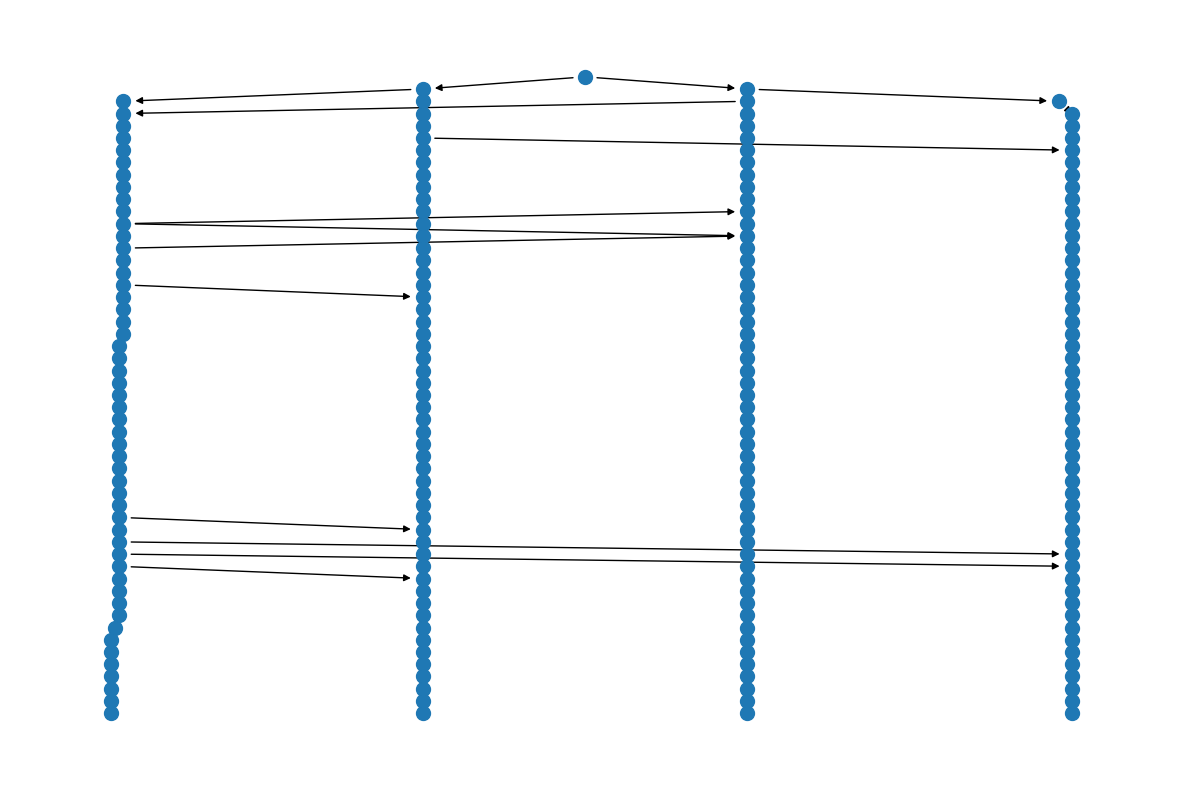

In [8]:
with open("pos.p", 'rb') as f:
    pos = pkl.load(f)
fig, ax = plt.subplots(figsize=(15,10))
G = nx.DiGraph(Ady_1)
#pos = graphviz_layout(G, prog='dot')
nx.draw_networkx_nodes(G, pos, node_size=100, ax=ax)
nx.draw_networkx_edges(G, pos, arrows=True, ax=ax)
for spine in ax.spines.values():
    spine.set_visible(False);

In [9]:

# intialize parameters
N = len(Ady)
r = .35
rd = .3
I = .8
G_in = 10
dt = .01
ro = τo = .5
key = random.PRNGKey(0)
tmax = 60
# initialize graph properties
n = jnp.zeros(N, dtype=jnp.int64)
#n = n.at[0].set(0)  # always the case given defn of obs dynamics
#n = n.at[1].set(10)

# obsolescence sites must always have a presence on the initial graph condition
obs_sub = jnp.zeros(N, dtype=jnp.bool_)
#obs_sub = obs_sub.at[0].set(True)
inn_front = jnp.zeros(N, dtype=jnp.bool_)
#inn_front = inn_front.at[1].set(True)

in_sub_pop = jnp.zeros(N, dtype=jnp.bool_)
#in_sub_pop = in_sub_pop.at[1].set(True)
sites = jnp.arange(N, dtype=jnp.int64)
#Ady = jnp.eye(N, k=1, dtype=jnp.bool_)

inverse_sons = Ady.sum(1)
inverse_sons = inverse_sons.at[inverse_sons==0].set(1)
inverse_sons = 1 / inverse_sons

# all sites in obsolescence subgraph have no population
#n = n.at[obs_sub].set(0)




In [10]:

@jit
def move_innov_front_explorer(key, inn_front, in_sub_pop, obs_sub, n):
    """Move all innovation fronts stochastically.
    
    Parameters
    ----------
    key
    inn_front : boolean array
        Indicates sites that are innovation fronts using True.
    in_sub_pop : boolean array
        Indicates which sites are in the populated subgraph.
    
    Returns
    -------
    key
    inn_front
    """
    # randomly choose innovation fronts to move
    key, subkey = random.split(key)
    front_moved = inn_front * (random.uniform(subkey, (N,)) > (1 - r*I*dt*n))
    
    # randomly choose amongst children to move innovation to
    key, subkey = random.split(key)
    #new_front_ix = jnp.argmax(Ady * random.uniform(subkey, (N,N)), axis=1) * front_moved
    new_front_ix = front_moved  @ Ady * sites
    # remove parent innovation fronts
    inn_front = inn_front.at[new_front_ix].set(True)
    #inn_front = jnp.logical_xor(inn_front, obs_sub)
    # set children innovation fronts
    inn_front = inn_front.at[0].set(False)  # bookkeeping
    in_sub_pop = in_sub_pop.at[new_front_ix].set(True)
    in_sub_pop = in_sub_pop.at[0].set(False)
    return key, inn_front, in_sub_pop

@jit
def move_innov_front(key, inn_front, in_sub_pop, n):
    """Move all innovation fronts stochastically.
    
    Parameters
    ----------
    key
    inn_front : boolean array
        Indicates sites that are innovation fronts using True.
    in_sub_pop : boolean array
        Indicates which sites are in the populated subgraph.
    
    Returns
    -------
    key
    inn_front
    """
    # randomly choose innovation fronts to move
    key, subkey = random.split(key)
    front_moved = inn_front * (random.uniform(subkey, (N,)) > (1 - r*I*dt*n))
    
    # randomly choose amongst children to move innovation to
    key, subkey = random.split(key)
    new_front_ix = jnp.argmax(Ady * random.uniform(subkey, (N,N)), axis=1) * front_moved
    
    # remove parent innovation fronts
    inn_front = jnp.logical_xor(inn_front, front_moved)
    # set children innovation fronts
    inn_front = inn_front.at[new_front_ix].set(True)
    inn_front = inn_front.at[0].set(False)  # bookkeeping
    in_sub_pop = in_sub_pop.at[new_front_ix].set(True)
    
    return key, inn_front, in_sub_pop

@jit
def move_obs_front(key, obs_sub, in_sub_pop, inn_front):
    """Grow obsolescence subgraph stochastically.
    
    TODO: allow obs subgraph to expand to all children instead of choosing one
          at a time
    
    Parameters
    ----------
    key
    obs_sub : boolean array
        Indicates sites that are obsolescence graph using True.
    
    Returns
    -------
    key
    obs_sub
    """
    # randomly choose obsolesence sites to move
    key, subkey = random.split(key)
    front_moved = obs_sub * (random.uniform(subkey, (N,)) < τo*dt)
    
    # move into all children vertices
    key, subkey = random.split(key)
    #new_front_ix = jnp.argmax(Ady * random.uniform(subkey, (N,N)), axis=1) * front_moved
    new_front_ix = front_moved @ Ady * sites
    
    # set children obsolescence sites
    obs_sub = obs_sub.at[new_front_ix].set(True)
    inn_front = inn_front.at[new_front_ix].set(False)
    in_sub_pop = in_sub_pop.at[new_front_ix].set(False)
    
    return key, obs_sub, in_sub_pop, inn_front


@jit
def one_loop(i, val):
    key = val[0]
    inn_front = val[1]
    obs_sub = val[2]
    in_sub_pop = val[3]
    n = val[4]

    # move innovation front
    #key, inn_front, in_sub_pop = move_innov_front(key, inn_front, in_sub_pop, n)
    key, inn_front, in_sub_pop = move_innov_front_explorer(key, inn_front, in_sub_pop, obs_sub, n)
#     debug.print("{x}", x=inn_front)
    
    # replicate
    key, subkey = random.split(key)
    to_replicate = random.poisson(subkey, Ady.T @ (r * inverse_sons * n * dt))
    n = n + to_replicate
#     debug.print("DREP {x}", x=(Ady.T @ (r * inverse_sons * n * dt))[:10])
#     debug.print("REP {x}", x=n[:10])
    
    # death
    key, subkey = random.split(key)
    to_died = random.poisson(subkey, rd * n * dt)
    n = jnp.maximum(n - to_died, 0)

    # growth
    key, subkey = random.split(subkey)
    G_dt = random.poisson(subkey, G_in*dt/in_sub_pop.sum(), (N,))
    n = (n + G_dt) * in_sub_pop

    # obsolescence front 
    key, obs_sub, in_sub_pop, inn_front = move_obs_front(key, obs_sub, in_sub_pop, inn_front)
    n = set_zero(n, obs_sub)
#     debug.print("OBS {x}", x=n[:10])
    
    return [key, inn_front, obs_sub, in_sub_pop, n]

@jit
def run_multiple_sims(i, val):
    key = val[0]
    inn_front_1 = val[1]
    obs_sub_1 = val[2]
    in_sub_pop_1 = val[3]
    n_1 = val[4]
    inn_front = val[5]
    obs_sub = val[6]
    in_sub_pop = val[7]
    n = val[8]
    
    key, inn_front_2, obs_sub_2, in_sub_pop_2, n_2 = fori_loop(0, 1000, one_loop, [key, inn_front_1, obs_sub_1, in_sub_pop_1, n_1])
    
    return [key, inn_front_1, obs_sub_1, in_sub_pop_1, n_1, inn_front+inn_front_2, obs_sub + obs_sub_2, in_sub_pop+in_sub_pop_2, n+n_2]

In [11]:
n, obs_sub, inn_front, in_sub_pop = Init_variables(n, obs_sub, inn_front, in_sub_pop)
assert not in_sub_pop[0]
assert (jnp.where(inn_front)[0]>0).all()

In [20]:
n_1, obs_sub_1, inn_front_1, in_sub_pop_1 = Init_variables(n, obs_sub, inn_front, in_sub_pop)
samples = 10
saving_time = 10*tmax/tmax
from time import time
start = time()
for i in range(samples):
    print(i)
    if i==0:
        key, t, n, inn_front, obs_sub, in_sub_pop = run_and_save([key, inn_front_1, obs_sub_1, in_sub_pop_1, n_1], int(saving_time/dt), int(tmax/dt))
        n_ave = np.array(n)/samples
        inn_front_ave = np.array(inn_front, dtype=int)
        obs_sub_ave = np.array(obs_sub, dtype=int)
        in_sub_pop_ave = np.array(in_sub_pop, dtype=int)
    else:
        key, t, n, inn_front, obs_sub, in_sub_pop = run_and_save([key, inn_front_1, obs_sub_1, in_sub_pop_1, n_1], int(saving_time/dt), int(tmax/dt))
        n_ave += np.array(n)/samples
        inn_front_ave += np.array(inn_front, dtype=int)
        obs_sub_ave += np.array(obs_sub, dtype=int)
        in_sub_pop_ave += np.array(in_sub_pop, dtype=int)
end = time()
print(end-start)
# sim = RKPropagator1D( N, sub_ix=[1, 2], obs = [0], Ady = Ady_1, n0=10, τo = ro, rd = rd, r = r, I = I, G_in= G_in, tmax = tmax, Δt = dt, λ = 1., method='frequency')
# n_int, L, time, H_sub_in_time, Obs_in_time, Inn_in_time = sim.run_and_save()

0
1
2
3
4
5
6
7
8
9
73.10887694358826


/tmp/ipykernel_1316515/2696945783.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.5)


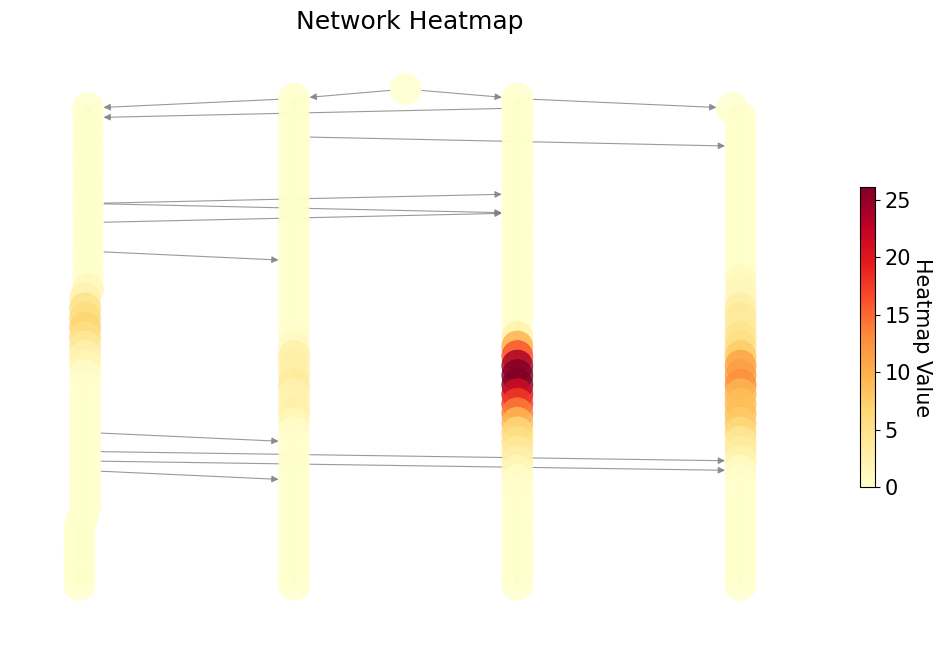

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Sample network creation (you can replace this with your network data)
G = nx.DiGraph(Ady_1)

# Generate a random heatmap data for each node (you can replace this with your actual data)
heatmap_data = {node: n_ave[-1][node] for node in G.nodes}

# Normalize the data to a colormap range
heatmap_values = list(heatmap_data.values())
min_value = min(heatmap_values)
max_value = max(heatmap_values)
normalized_values = [(value - min_value) / (max_value - min_value) for value in heatmap_values]

# Plot the network
plt.figure(figsize=(10, 6))
#pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=False, node_size=500, cmap=plt.cm.YlOrRd, node_color=normalized_values, font_size=10, font_color='black', width=0.8, edge_color='gray', alpha=0.8, linewidths=0.5)

# Add colorbar to represent the heatmap
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=min_value, vmax=max_value))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.5)
cbar.set_label('Heatmap Value', rotation=270, labelpad=15)

# Show the plot
plt.title("Network Heatmap")
plt.show()

/tmp/ipykernel_1316515/2696945783.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.5)


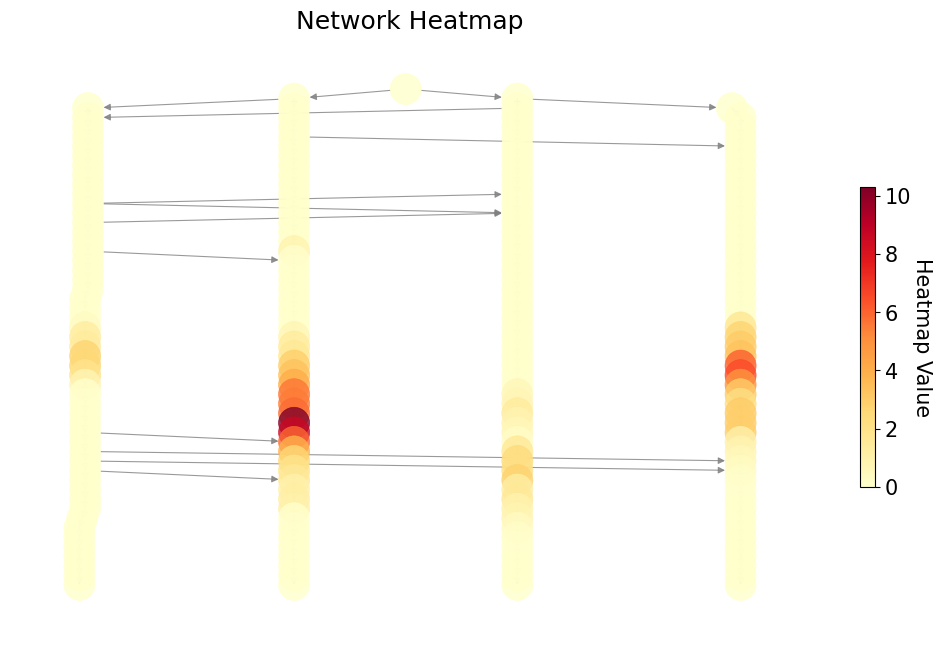

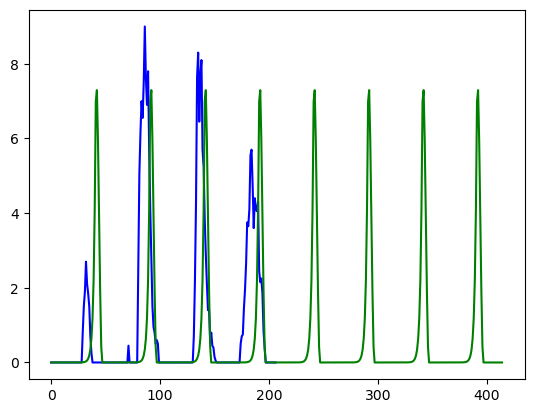

In [31]:
plt.plot(n_ave[-1], color='b')
plt.plot(n_int[-1], color='g')
#plt.axis(xmin=0, xmax=30)

/tmp/ipykernel_1303519/403499588.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.5)


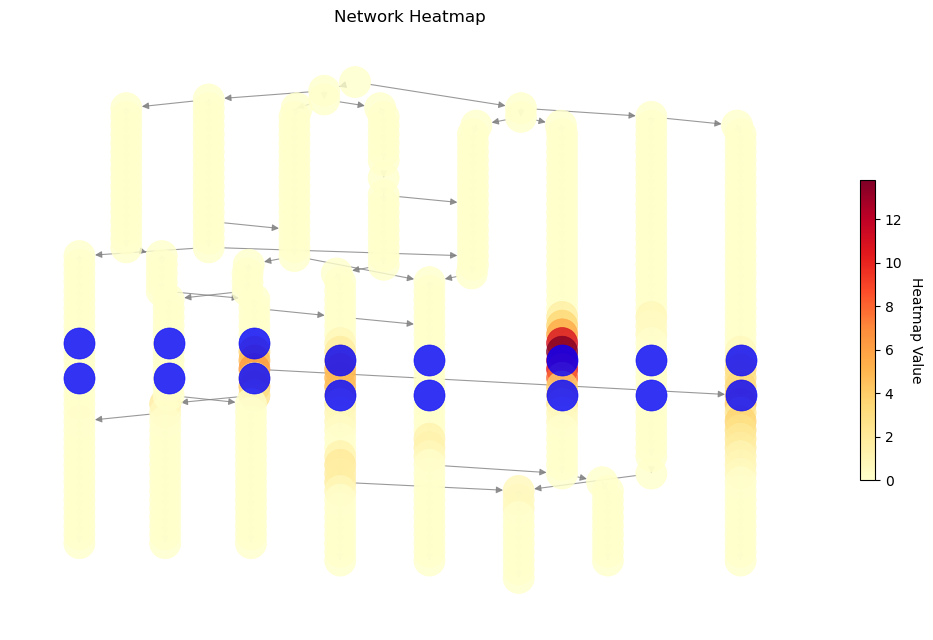

/tmp/ipykernel_1303519/403499588.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.5)


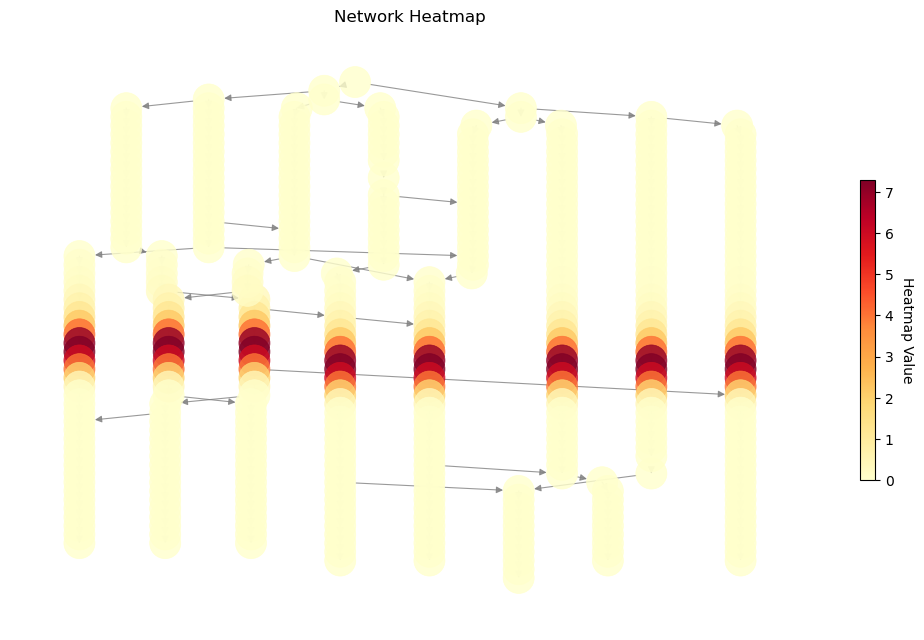

In [22]:


# Sample network creation (you can replace this with your network data)
G = nx.DiGraph(Ady_1)

# Generate a random heatmap data for each node (you can replace this with your actual data)
heatmap_data = {node: n_ave[-1][node] for node in G.nodes}

# Normalize the data to a colormap range
heatmap_values = list(heatmap_data.values())
min_value = min(heatmap_values)
max_value = max(heatmap_values)
normalized_values = [(value - min_value) / (max_value - min_value) for value in heatmap_values]

# Plot the network
plt.figure(figsize=(10, 6))
#pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=False, node_size=500, cmap=plt.cm.YlOrRd, node_color=normalized_values, font_size=10, font_color='black', width=0.8, edge_color='gray', alpha=0.8, linewidths=0.5)

# Add colorbar to represent the heatmap
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=min_value, vmax=max_value))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.5)
cbar.set_label('Heatmap Value', rotation=270, labelpad=15)
nx.draw(G.subgraph(Obs_in_time[-1]), pos, with_labels=False, node_size=500, node_color='blue', font_size=10, font_color='black', width=0.8, edge_color='gray', alpha=0.8, linewidths=0.5)
nx.draw(G.subgraph(Inn_in_time[-1]), pos, with_labels=False, node_size=500, node_color='blue', font_size=10, font_color='black', width=0.8, edge_color='gray', alpha=0.8, linewidths=0.5)

# Show the plot
plt.title("Network Heatmap")
plt.show()

heatmap_data = {node: n_int[-1][node] for node in G.nodes}

# Normalize the data to a colormap range
heatmap_values = list(heatmap_data.values())
min_value = min(heatmap_values)
max_value = max(heatmap_values)
normalized_values = [(value - min_value) / (max_value - min_value) for value in heatmap_values]

# Plot the network
plt.figure(figsize=(10, 6))
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=False, node_size=500, cmap=plt.cm.YlOrRd, node_color=normalized_values, font_size=10, font_color='black', width=0.8, edge_color='gray', alpha=0.8, linewidths=0.5)

# Add colorbar to represent the heatmap
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=min_value, vmax=max_value))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.5)
cbar.set_label('Heatmap Value', rotation=270, labelpad=15)

# Show the plot
plt.title("Network Heatmap")

plt.show()

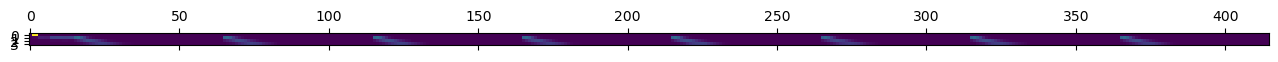

In [61]:
plt.matshow(inn_front_ave)

/tmp/ipykernel_998621/810424578.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.5)


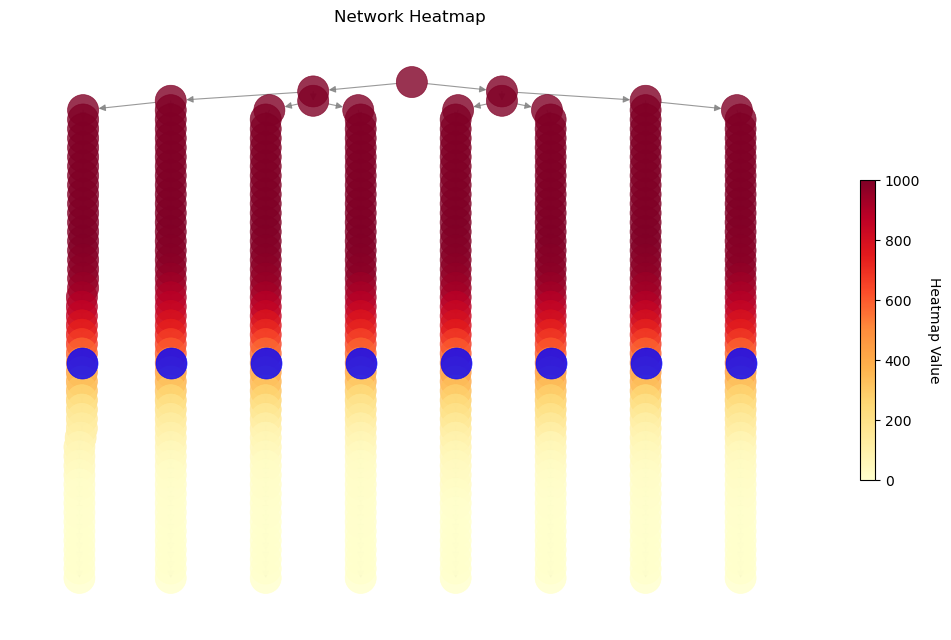

In [88]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Sample network creation (you can replace this with your network data)
G = nx.DiGraph(Ady_1)

# Generate a random heatmap data for each node (you can replace this with your actual data)
heatmap_data = {node: obs_sub_ave[-1][node] for node in G.nodes}
# Normalize the data to a colormap range
heatmap_values = list(heatmap_data.values())
min_value = min(heatmap_values)
max_value = max(heatmap_values)
normalized_values = [(value - min_value) / (max_value - min_value) for value in heatmap_values]

# Plot the network
plt.figure(figsize=(10, 6))
#pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=False, node_size=500, cmap=plt.cm.YlOrRd, node_color=normalized_values, font_size=10, font_color='black', width=0.8, edge_color='gray', alpha=0.8, linewidths=0.5)

# Add colorbar to represent the heatmap
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=min_value, vmax=max_value))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.5)
cbar.set_label('Heatmap Value', rotation=270, labelpad=15)

# Show the plot
plt.title("Network Heatmap")
nx.draw(G.subgraph(Obs_in_time[-1]), pos, with_labels=False, node_size=500, node_color='blue', font_size=10, font_color='black', width=0.8, edge_color='gray', alpha=0.8, linewidths=0.5)
plt.show()


/tmp/ipykernel_998621/2976644706.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.5)


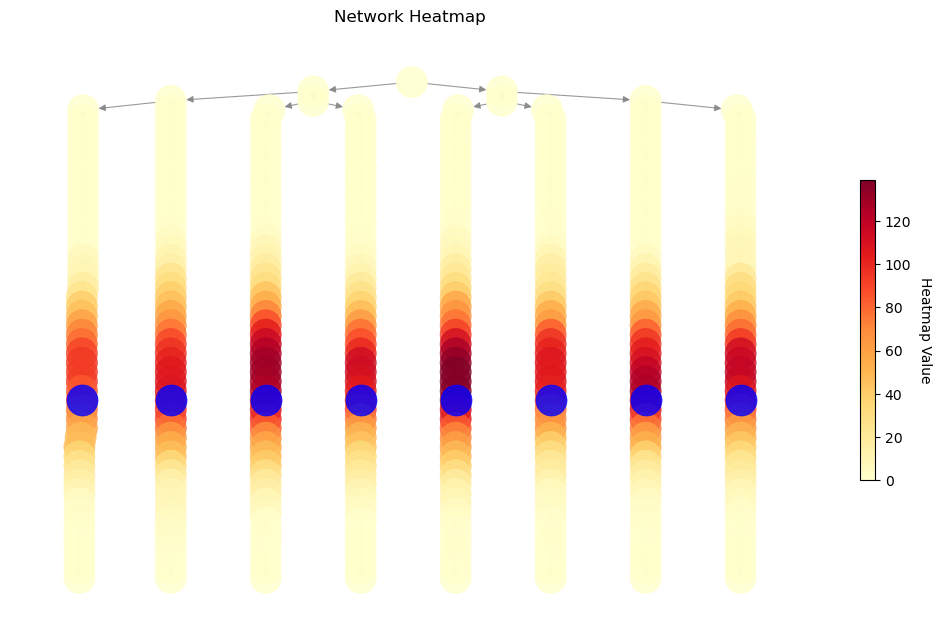

In [89]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Sample network creation (you can replace this with your network data)
G = nx.DiGraph(Ady_1)

# Generate a random heatmap data for each node (you can replace this with your actual data)
heatmap_data = {node: inn_front_ave[-1][node] for node in G.nodes}

# Normalize the data to a colormap range
heatmap_values = list(heatmap_data.values())
min_value = min(heatmap_values)
max_value = max(heatmap_values)
normalized_values = [(value - min_value) / (max_value - min_value) for value in heatmap_values]

# Plot the network
plt.figure(figsize=(10, 6))
#pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=False, node_size=500, cmap=plt.cm.YlOrRd, node_color=normalized_values, font_size=10, font_color='black', width=0.8, edge_color='gray', alpha=0.8, linewidths=0.5)

# Add colorbar to represent the heatmap
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=min_value, vmax=max_value))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.5)
cbar.set_label('Heatmap Value', rotation=270, labelpad=15)

# Show the plot
plt.title("Network Heatmap")
nx.draw(G.subgraph(Inn_in_time[-1]), pos, with_labels=False, node_size=500, node_color='blue', font_size=10, font_color='black', width=0.8, edge_color='gray', alpha=0.8, linewidths=0.5)
plt.show()


/tmp/ipykernel_998621/2316437100.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, shrink=0.5)


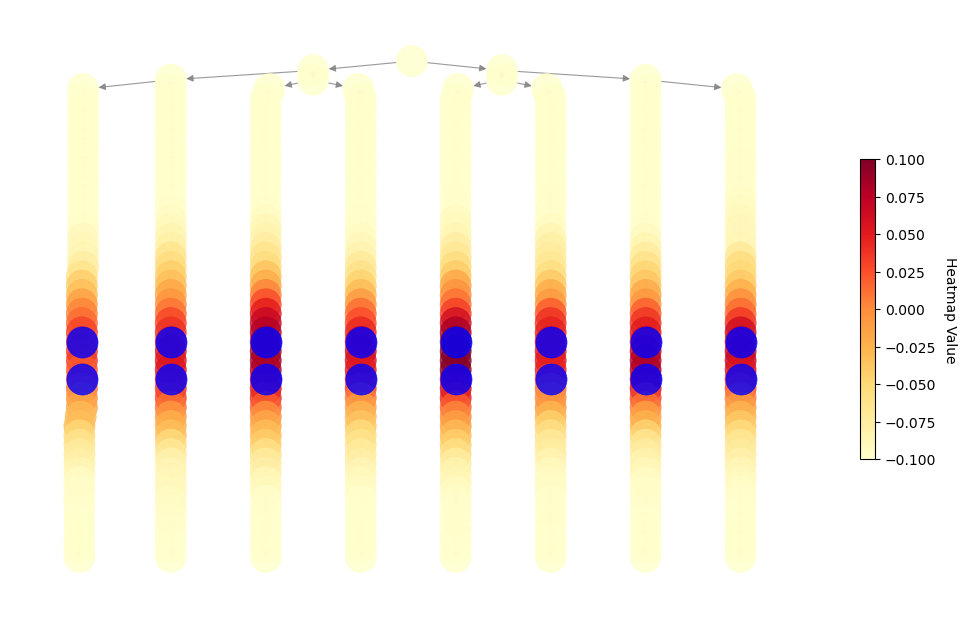

In [90]:
G = nx.DiGraph(Ady_1)

# Generate a random heatmap data for each node (you can replace this with your actual data)
heatmap_data = {node: 0 for node in G.nodes}

# Normalize the data to a colormap range
heatmap_values = list(heatmap_data.values())
min_value = min(heatmap_values)
max_value = max(heatmap_values)
#normalized_values = [(value - min_value) / (max_value - min_value) for value in heatmap_values]

# Plot the network
plt.figure(figsize=(10, 6))
pos = graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=False, node_size=500, cmap=plt.cm.YlOrRd, node_color=normalized_values, font_size=10, font_color='black', width=0.8, edge_color='gray', alpha=0.8, linewidths=0.5)

# Add colorbar to represent the heatmap
sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=min_value, vmax=max_value))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.5)
cbar.set_label('Heatmap Value', rotation=270, labelpad=15)
nx.draw(G.subgraph(Inn_in_time[-1]), pos, with_labels=False, node_size=500, node_color='blue', font_size=10, font_color='black', width=0.8, edge_color='gray', alpha=0.8, linewidths=0.5)
nx.draw(G.subgraph(Obs_in_time[-1]), pos, with_labels=False, node_size=500, node_color='blue', font_size=10, font_color='black', width=0.8, edge_color='gray', alpha=0.8, linewidths=0.5)
plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


for i in range(40):
    heatmap_data = {node: n_int[i*100][node] for node in G.nodes}

    # Normalize the data to a colormap range
    heatmap_values = list(heatmap_data.values())
    min_value = min(heatmap_values)
    max_value = max(heatmap_values)
    normalized_values = [(value - min_value) / (max_value - min_value) for value in heatmap_values]

    # Plot the network
    plt.figure(figsize=(10, 6))
    pos = graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=True, node_size=500, cmap=plt.cm.YlOrRd, node_color=normalized_values, font_size=10, font_color='black', width=0.8, edge_color='gray', alpha=0.8, linewidths=0.5)

    # Add colorbar to represent the heatmap
    sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=min_value, vmax=max_value))
    sm.set_array([])
    cbar = plt.colorbar(sm, shrink=0.5)
    cbar.set_label('Heatmap Value', rotation=270, labelpad=15)

    # Show the plot
    plt.title("Network Heatmap")
    plt.show()

In [ ]:
#G = nx.karate_club_graph()

# Generate random densities for each node at each time step
num_time_steps = len(n)
node_densities = n

# Function to update node colors in each frame of the animation
def update_frame(frame):
    plt.clf()  # Clear the previous plot
    plt.title(f"Time Step {frame}")
    
    # Normalize the density values for colormap
    min_density = np.min(node_densities)
    max_density = np.max(node_densities)
    normalized_densities = (node_densities[frame] - min_density) / (max_density - min_density)

    # Plot the network with node colors based on density
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=500, cmap=plt.cm.YlOrRd, node_color=normalized_densities, font_size=10, font_color='black', width=0.8, edge_color='gray', alpha=0.8, linewidths=0.5)
    
# Create the animation
fig = plt.figure(figsize=(10, 6))
ani = animation.FuncAnimation(fig, update_frame, frames=num_time_steps, interval=1000, repeat=True)

# Save the animation as a video file (MP4 format)
writer = animation.writers['ffmpeg'](fps=2)
ani.save('network_animation.mp4', writer=writer)

# Show the animation (optional)
# plt.show()

In [32]:
sim.x

{57: 0.3593946265222002,
 107: 0.2068877990116868,
 157: 0.3523428439362112,
 8: 0}

In [34]:
sim = RKPropagator1D( N, sub_ix=[1, 2], inn = [1, 2], obs = [0], Ady = Ady_1, n0=10, τo = ro, rd = rd, r = r, I = I, G_in= G_in, tmax = tmax, Δt = dt, λ = 1., method='frequency')
n_int, L, time, H_sub_in_time, Obs_in_time, Inn_in_time = sim.run_and_save()

1 {1: 0, 2: 0}
2 {1: 0.028055916083937, 2: 0}
1 {1: 0.028055916083937, 2: 0.028055916083937}
2 {1: 0.056167580754930134, 2: 0.028055916083937}
1 {1: 0.056167580754930134, 2: 0.056167580754930134}
2 {1: 0.0843348270178362, 2: 0.056167580754930134}
1 {1: 0.0843348270178362, 2: 0.0843348270178362}
2 {1: 0.11255748837774669, 2: 0.0843348270178362}
1 {1: 0.11255748837774669, 2: 0.11255748837774669}
2 {1: 0.14083539883848933, 2: 0.11255748837774669}
1 {1: 0.14083539883848933, 2: 0.14083539883848933}
2 {1: 0.16916839290113417, 2: 0.14083539883848933}
1 {1: 0.16916839290113417, 2: 0.16916839290113417}
2 {1: 0.197556305562504, 2: 0.16916839290113417}
1 {1: 0.197556305562504, 2: 0.197556305562504}
2 {1: 0.2259989723136894, 2: 0.197556305562504}
1 {1: 0.2259989723136894, 2: 0.2259989723136894}
2 {1: 0.2544962291385681, 2: 0.2259989723136894}
1 {1: 0.2544962291385681, 2: 0.2544962291385681}
2 {1: 0.2830479125123289, 2: 0.2544962291385681}
1 {1: 0.2830479125123289, 2: 0.2830479125123289}
2 {1: 0.31

7 {7: 0.8636827097308352, 57: 0.3045380436919423, 107: 0.1772347325184672, 157: 0.3045380436919423}
57 {7: 0.8728885951342363, 57: 0.3045380436919423, 107: 0.1772347325184672, 157: 0.3045380436919423}
7 {7: 0.8728885951342363, 57: 0.3111998547089329, 107: 0.1772347325184672, 157: 0.3045380436919423}
107 {7: 0.8820944805376375, 57: 0.3111998547089329, 107: 0.1772347325184672, 157: 0.3045380436919423}
157 {7: 0.8820944805376375, 57: 0.3111998547089329, 107: 0.18135246914904718, 157: 0.3045380436919423}
7 {7: 0.8820944805376375, 57: 0.3111998547089329, 107: 0.18135246914904718, 157: 0.3111998547089329}
57 {7: 0.8913726631499383, 57: 0.3111998547089329, 107: 0.18135246914904718, 157: 0.3111998547089329}
7 {7: 0.8913726631499383, 57: 0.31791761190840323, 107: 0.18135246914904718, 157: 0.3111998547089329}
107 {7: 0.9006508457622392, 57: 0.31791761190840323, 107: 0.18135246914904718, 157: 0.3111998547089329}
157 {7: 0.9006508457622392, 57: 0.31791761190840323, 107: 0.18550980093568697, 157: 0

KeyError: 7